# Variational Autoencoder

Build a basic Variational Autoencoder.

Train it on the following dataset: https://github.com/bchao1/Anime-Face-Dataset


## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

from keras.layers import Conv2D as conv
from keras.layers import Conv2DTranspose as convt
from keras.layers import BatchNormalization as normalization
from keras.layers import Flatten, Dense, Input

## Parameters

In [2]:
# set a random seed
np.random.seed(50)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

# Shape of input images
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3,)

## Download the Dataset

You will download the Anime Faces dataset and save it to a local directory.

In [3]:
# make the data directory
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/learning-datasets/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Preprocessing

In [4]:
# Preprocessing

def get_dataset_slice_paths(image_dir):
  #returns a list of paths to the image files
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  #preprocesses the images
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=INPUT_SHAPE)

  return image

In [18]:
# get the list containing the image paths
paths = get_dataset_slice_paths("/tmp/anime/images/")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%)
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

print(f'number of batches in the training set: {len(training_dataset)}')

number of batches in the training set: 26


## Display Utilities

We've also provided some utilities to help in visualizing the data.

In [6]:
# Plots a sample in a grid
def display_faces(dataset, size=9):
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)

# Displays a row of images
def display_one_row(disp_images, offset, shape=(28, 28)):
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)

# Displays input and predicted images
def display_results(disp_input_images, disp_predicted):
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

# Helper function to plot 16 images at a time
def generate_and_save_images(model, epoch, step, test_input):
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

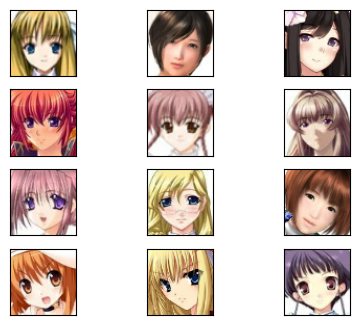

In [7]:
display_faces(training_dataset, size=12)

## VAE Model

### Sampling Layer

In [8]:
# Sampling class, adds a Gaussian noise to the output
# of the encoder, before feeding it to the decoder

class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    # inputs -- output tensor from the encoder

    # retrieve mean and variance of the Gaussian distribuion
    mu, sigma = inputs

    # retrieve batch size and dimension of noise
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # generate random noise and combine it with inputs
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon

    # return tensor with random noise combined
    return  z

### ENCODER

In [9]:
# ENCODER layers

def encoder_layers(inputs, latent_dim):
  """
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space
  """

  # First conv layer
  x = conv(32, 3, 2, 'same', activation='relu')(inputs)
  x = normalization()(x)

  # Second conv layer
  x = conv(64, 3, 2, 'same', activation='relu')(x)
  x = normalization()(x)

  # Third conv layer
  x = conv(128, 3, 2, 'same', activation='relu')(x)
  batch_3 = normalization()(x)

  # Flat before feeding to dense layers
  x = Flatten()(batch_3)

  # Dense layer
  x = Dense(1024, activation='relu')(x)
  x = normalization()(x)

  # Branch with two dense layers to output mean and std deviation
  mu = Dense(latent_dim)(x)
  sigma = Dense(latent_dim)(x)

  # return mean, std deviation, and shape of image before flattening
  return mu, sigma, batch_3.shape

In [10]:
# ENCODER model with sampling layer before output

def encoder_model(latent_dim, input_shape):
  """
    latent_dim -- dimension of the latent space
    input_shape -- shape of the batch
  """
  # declare input layer
  inputs = Input(input_shape)

  # Encoder layers
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)

  # Sampling layer to add noise
  z = Sampling()((mu,sigma))

  # Declare all model architecture
  model = tf.keras.Model(inputs, outputs=[mu,sigma,z])

  # print summary of the model
  model.summary()

  # return model, and shape before flattening
  return model, conv_shape

### DECODER

In [11]:
# DECODER layers

def decoder_layers(inputs, conv_shape):
  """
    inputs -- output of the encoder
    conv_shape -- shape of the tensor before flattening
  """
  # retrieve shape before flattening in the encoder
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]

  # Dense layer
  x = Dense(units, activation='relu')(inputs)
  x = normalization()(x)

  # reshape to match tensor before flattening in the encoder
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

  # first conv transpose layer
  x = convt(128, 3, 2, 'same', activation='relu')(x)
  x = normalization()(x)

  # second conv transpose layer
  x = convt(64, 3, 2, 'same', activation='relu')(x)
  x = normalization()(x)

  # third conv transpose layer
  x = convt(32, 3, 2, 'same', activation='relu')(x)
  x = normalization()(x)

  # fourth conv transpose layer to match desired image output
  x = convt(3, 3, 1, 'same', activation='sigmoid')(x)

  return x

In [12]:
# DECODER model

def decoder_model(latent_dim, conv_shape):
  """
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening
  """
  # declare input layer
  inputs = Input(shape=(latent_dim, ))

  # Decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare decoder model
  model = tf.keras.Model(inputs, outputs)

  # print model summary
  model.summary()

  return model

### Kullback–Leibler loss

In [13]:
# Implement KL-loss from https://arxiv.org/abs/2002.07514

def kl_reconstruction_loss(mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### VAE model

In [14]:
def vae_model(encoder, decoder, input_shape):
  """
    encoder -- encoder model
    decoder -- decoder model
    input_shape -- shape of batch
  """
  # declare input layer
  inputs = Input(shape=input_shape)

  # Encoder
  mu, sigma, z = encoder(inputs)

  # Decoder
  reconstructed = decoder(z)

  # declare VAE model
  model = tf.keras.Model(inputs, reconstructed)

  # Use costumized KL-loss
  loss = kl_reconstruction_loss(mu, sigma)
  model.add_loss(loss)

  # return VAE model

  return model

In [15]:
# Initialize Encoder and retireve shape before flattening
encoder, conv_shape = encoder_model(LATENT_DIM, INPUT_SHAPE)

# Initialize decoder
decoder = decoder_model(LATENT_DIM, conv_shape)

# Initialize VAE
vae = vae_model(encoder, decoder, INPUT_SHAPE)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['batch_normalization[0][0

## Train the Model


In [16]:
# configuration for training
epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

1/1 [==============================] - 0s 20ms/step


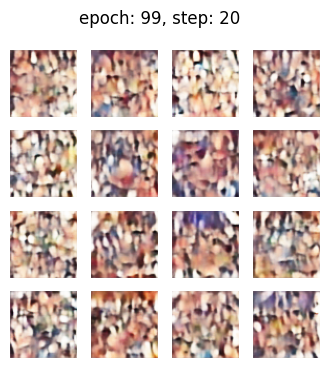

Epoch: 99 step: 20 mean loss = 212.08823
Epoch: 99 step: 21 mean loss = 212.05437
Epoch: 99 step: 22 mean loss = 212.02065
Epoch: 99 step: 23 mean loss = 211.98656
Epoch: 99 step: 24 mean loss = 211.95311
Epoch: 99 step: 25 mean loss = 211.91899


In [17]:
# Training loop.

# random vector for generation
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# print initial images
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:

      # forward prop
      reconstructed = vae(x_batch_train)

      #reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, (-1,1))
      flattened_outputs = tf.reshape(reconstructed, (-1,1))

      loss = mse_loss(flattened_inputs, flattened_outputs)*64*64*3

      loss += sum(vae.losses)

    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))